In [ ]:
%load_ext autoreload
%autoreload 2

# Core: Training

> The `training.core` module contains the core bits required to train text/NLP models with fast.ai

In [ ]:
# |default_exp training.core
# |default_cls_lvl 3

In [ ]:
# |export
from __future__ import annotations

import gc, importlib, sys, traceback

from accelerate.logging import get_logger
from dataclasses import dataclass
from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.imports import *
from fastai.learner import *
from fastai.torch_core import *
from fastai.torch_imports import *
from transformers import (
    AutoConfig,
    AutoTokenizer,
    PretrainedConfig,
    PreTrainedTokenizerBase,
    PreTrainedModel,
    AutoModelForSequenceClassification,
)
from transformers import logging as hf_logging

from blurr.data.core import TextInput
from blurr.utils import clean_memory, get_hf_objects, set_seed, PreCalculatedLoss

In [ ]:
# |hide
import pdb
from fastai.metrics import accuracy, F1Score, accuracy_multi, F1ScoreMulti
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.data.transforms import DataLoader, DataLoaders, Datasets
from fastai.optimizer import Adam, OptimWrapper, params
from datasets import concatenate_datasets, load_dataset, Value
from fastai.data.block import MultiCategoryBlock, CategoryBlock, ColReader, ColSplitter, DataBlock, ItemGetter, RandomSplitter, FuncSplitter
from fastai.losses import BaseLoss, BCEWithLogitsLossFlat, CrossEntropyLossFlat
from fastai.text.data import SortedDL
from fastcore.test import *
import nbdev

from blurr.utils import (
    print_versions,
    set_seed,
    PreCalculatedLoss,
    PreCalculatedCrossEntropyLoss,
    PreCalculatedBCELoss,
    PreCalculatedMSELoss,
)
from blurr.data.core import *

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()
logger = get_logger(__name__)

load_dotenv()

False

In [ ]:
# |hide
# |notest
torch.cuda.set_device(0)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: NVIDIA GeForce RTX 3090


In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.13.1
fastai: 2.7.11
transformers: 4.26.1


## Setup

We'll use a subset of `imdb` to demonstrate how to configure your BLURR for sequence classification tasks. **BLURR** is designed to work with Hugging Face `Dataset` and/or pandas `DataFrame` objects

### Multiclass

In [ ]:
imdb_dsd = load_dataset("imdb", split=["train", "test"])

# build HF `Dataset` objects
train_ds = imdb_dsd[0].add_column("is_valid", [False] * len(imdb_dsd[0])).shuffle().select(range(1000))
valid_ds = imdb_dsd[1].add_column("is_valid", [True] * len(imdb_dsd[1])).shuffle().select(range(200))
imdb_ds = concatenate_datasets([train_ds, valid_ds])

# build a `DataFrame` representation as well
imdb_df = pd.DataFrame(imdb_ds)

print(len(train_ds), len(valid_ds))
print(len(imdb_df[imdb_df["is_valid"] == False]), len(imdb_df[imdb_df["is_valid"] == True]))
imdb_df.head()

Found cached dataset imdb (/home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/2 [00:00<?, ?it/s]

1000 200
1000 200


,text,label,is_valid
0,"Love Trap is not a short, it's quite obviously a full length feature film with a running time of 105 minutes.<br /><br />While I'm writing this, I might as well talk a bit more about Love Trap. I'm frequently asked what makes Love Trap different... this is how I respond to that question: 1) It introduces characters - one in particular - that have never been seen before in film, period.<br /><br />2) It reveals more truth about love, and delves more deeply into the very concept of love, than any other U.S. film ever made, in my humble opinion.<br /><br />3) Structurally, as in the way the s...",1,False
1,"Loved Part One, The Impossible Planet, but whoops, what a disappointment part two 'The Satan Pit' is. The cliffhanger of something apparently rising out of the pit was - nothing coming out of the pit. Then ages spent crawling round air vents to pad out the story, the Beast a roaring thing empty of intelligence, so no Doctor/villain confrontation I'd been anticipating. The TARDIS is somehow inside the pit despite the pit not being open till long after the TARDIS fell through the planet crust. And finally another ready made solution which existed for no logical reason - I mean, why not plung...",0,False
2,"I can understand after watching this again for the first time in many years how it is considered one of the worst Laurel & Hardy's. For me, it isn't as close to as bad as ""Air Raid Wardens"" and ""The Bullfighters"", but there are some definite huge flaws in it. The film is set up to show Laurel and Hardy as the owners and instructors of the dance studio. Hardy is funny as the prancing lead of a ""London Bridge"" dance, surrounded by 20th Century Fox starlets, while in the next room, Laurel teaches the beginners ballet while wearing a ballerina outfit. A clumsy carpenter spills glue on the floo...",0,False
3,"Simon Pegg stars as Sidney Young, a stereotypically clumsy idiot Brit working as a celebrity journalist in this US comedy. After getting a very lucky break he starts work at the highly respected Sharps magazine run by a reliably on form Jeff Bridges in New York. It's more The Devil Wears Prada than Shaun of the Dead. The unlikely love interest is provided by Kirsten Dunst who works well with Pegg for the laughs but they don't exactly set the screen ablaze with their passion.<br /><br />Sidney goes through some emotional challenges while trying to decide if he should forget about his journa...",0,False
4,"I bought this (it was only $3, ok?) under the title ""Grey Matter"". The novelty of seeing Sherriff Roscoe in a non-DukesOfHazzard role intrigued me. As the other reviewers warned, it's a pretty boring tale of a top secret government experiment gone awry.<br /><br />And yes, there are plenty of establishing shots, especially of a house with a pool in front of it. Some of the characters and interiors are so nondescript I guess the filmmakers worried we might forget who is who, so they keep tipping us off by first showing the outside of the buildings. It's actually kinda funny. After awhile th...",0,False


In [ ]:
label_names = imdb_dsd[0].features["label"].names
label_names

['neg', 'pos']

### Multilabel

In [ ]:
civil_dsd = load_dataset("civil_comments", split=["train", "validation"])

# round the floats
civil_label_names = ["toxicity", "severe_toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]


def round_targs(example):
    for lbl in civil_label_names:
        example[lbl] = np.round(example[lbl])
    return example


# convert floats to ints
def fix_dtypes(ds):
    new_features = ds.features.copy()
    for lbl in civil_label_names:
        new_features[lbl] = Value("int32")
    return ds.cast(new_features)


# build HF `Dataset` objects
civil_train_ds = civil_dsd[0].add_column("is_valid", [False] * len(civil_dsd[0])).shuffle().select(range(1000))
civil_train_ds = civil_train_ds.map(round_targs)
civil_train_ds = fix_dtypes(civil_train_ds)

civil_valid_ds = civil_dsd[1].add_column("is_valid", [True] * len(civil_dsd[1])).shuffle().select(range(200))
civil_valid_ds = civil_valid_ds.map(round_targs)
civil_valid_ds = fix_dtypes(civil_valid_ds)

civil_ds = concatenate_datasets([civil_train_ds, civil_valid_ds])

# build a `DataFrame` representation as well
civil_df = pd.DataFrame(civil_ds)

print(len(civil_train_ds), len(civil_valid_ds))
print(len(civil_df[civil_df["is_valid"] == False]), len(civil_df[civil_df["is_valid"] == True]))
civil_df.head()

Found cached dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab)


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

1000 200
1000 200


,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,is_valid
0,I wouldn't be surprised if LW had been broken up with and chose to omit that from the letter.,0,0,0,0,0,0,0,False
1,"Remember the huge used car lot at Kapiolani and Kalakaua? The proposed Hawaii Convention Center was doubtless to be a success. Hawaii was the world's most desired destination. Tourists galore. Business conventions galore..ect. etc. etc. Construction became a foregone conclusion from disaster to just finish it already. When the politics, budget problems, tax bailouts, and contract lawsuits over the poor business planning, foolhardy engineering costs estimates (ECA), and gov't subsidies were finally done, how did the Convention Center perform for the next decade? A white elephant need...",0,0,0,0,0,0,0,False
2,"Mr. Mason, I certainly appreciate your comment. BUT, the speed limit could be limited to any amount, and drivers would not adhere to it. Strictly enforced? That means multiple troopers out on patrol at multiple points on the highway. Now, if we had an income tax, that option might be even feasible to some degree. However, in our current budget climate...your statement is merely wishful thinking.",0,0,0,0,0,0,0,False
3,"""In 2015, more physicians returned from abroad than moved abroad, resulting in a net gain of \n110 physicians from international migration""\n\nThis is the exact quote from the report. And it was 2015, when the exchange rate was still ok. And the increase in number of physicians has been declining over the last few years. \n\nLiberal times are always good time for brain drain.",0,0,0,0,0,0,0,False
4,ISIS and their followers like this terrorist all believe in giving the death penalty to all members of the LGBT community. This is hardly the belief of a single man. Their extremist Wahhabi Sunni version of Islam teaches such intolerance and hatred. And there are many millions of Wahhabi followers in the world. \n\nDid you miss all of the gay men that ISIS executed 6 months ago for sodomy? They punished them by throwing them off the rooftop of a tall building:\n\nhttp://www.news.com.au/world/islamic-state-group-targets-gays-with-brutal-public-killings/news-story/3b55d4e061e005aa841...,0,0,0,0,0,0,0,False


## Base API

Base plitters for defining paramater groups, model wrapper, and model callback

### `blurr_splitter`s -

In [ ]:
# |export
def blurr_params(modules: Module | list[Module]):
    "Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules"
    if not is_listy(modules):
        modules = [modules]
    return [p for m in modules for p in m.parameters()]

In [ ]:
nbdev.show_doc(blurr_params, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/core.py#L42){target="_blank" style="float:right; font-size:smaller"}

### blurr_params

>      blurr_params
>                    (modules:fastai.torch_core.Module|list[fastai.torch_core.Mo
>                    dule])

Like fast.ai's `params()` method, this method returns all parameters of `m` but also works with lists of modules

In [ ]:
# |export
def blurr_splitter(m: Module):
    """Splits the Hugging Face model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L([m for m_name, m in list(top_module.named_children())])
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/core.py#L49){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter

>      blurr_splitter (m:fastai.torch_core.Module)

Splits the Hugging Face model based on various model architecture conventions

In [ ]:
# |export
def blurr_splitter_on_head(m: Module):
    """Creates two layers groups: One for the backbone and one for the pooler/classification head"""
    model = m.hf_model if (hasattr(m, "hf_model")) else m
    root_modules = list(model.named_children())
    backbone_module_name, backbone_module = root_modules[0]

    groups = L(backbone_module)
    groups.append(L([m for m_name, m in root_modules[1:]]))

    return groups.map(blurr_params).filter(lambda el: len(el) > 0)

In [ ]:
nbdev.show_doc(blurr_splitter_on_head, title_level=3)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/core.py#L61){target="_blank" style="float:right; font-size:smaller"}

### blurr_splitter_on_head

>      blurr_splitter_on_head (m:fastai.torch_core.Module)

Creates two layers groups: One for the backbone and one for the pooler/classification head

### `BaseModelWrapper` -

In [ ]:
# |export
class BaseModelWrapper(Module):
    def __init__(
        self,
        # Your Hugging Face model
        hf_model: PreTrainedModel,
        # If True, hidden_states will be returned and accessed from Learner
        output_hidden_states: bool = False,
        # If True, attentions will be returned and accessed from Learner
        output_attentions: bool = False,
        # Any additional keyword arguments you want passed into your models forward method
        hf_model_kwargs={},
    ):
        super().__init__()

        store_attr()
        self.hf_model = hf_model.cuda() if torch.cuda.is_available() else hf_model
        self.hf_model_fwd_args = list(inspect.signature(self.hf_model.forward).parameters.keys())

    def forward(self, x):
        for k in list(x):
            if k not in self.hf_model_fwd_args:
                del x[k]

        return self.hf_model(
            **x,
            output_hidden_states=self.output_hidden_states,
            output_attentions=self.output_attentions,
            return_dict=True,
            **self.hf_model_kwargs,
        )

Note that `BaseModelWrapper` includes some nifty code for just passing in the things your model needs, as not all transformer architectures require/use the same information.

### `BaseModelCallback` -

In [ ]:
# |export
class BaseModelCallback(Callback):
    def __init__(
        self,
        # Additional keyword arguments passed to `BaseModelWrapper`
        base_model_wrapper_kwargs: dict = {},
    ):
        self.base_model_wrapper_kwargs = base_model_wrapper_kwargs

    def after_create(self):
        if isinstance(self.learn.model, PreTrainedModel):
            self.learn.model = BaseModelWrapper(self.learn.model, **self.base_model_wrapper_kwargs)

    def before_batch(self):
        self.hf_loss = None

    def after_pred(self):
        model_outputs = self.pred
        self.learn.blurr_model_outputs = {}

        for k, v in model_outputs.items():
            # if the "labels" are included, we are training with target labels in which case the loss is returned
            if k == "loss" and isinstance(self.learn.loss_func, PreCalculatedLoss):
                self.hf_loss = to_float(v)
            # the logits represent the prediction
            elif k == "logits":
                self.learn.pred = v
            # add any other things included in model_outputs as blurr_{model_output_key}
            else:
                self.learn.blurr_model_outputs[k] = v

    def after_loss(self):
        # if we already have the loss from the model, update the Learner's loss to be it
        if self.hf_loss is not None:
            self.learn.loss_grad = self.hf_loss
            self.learn.loss = self.learn.loss_grad.clone()

We use a `Callback` for handling the [`ModelOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.file_utils.ModelOutput) returned by Hugging Face transformers. It allows us to associate anything we want from that object to our `Learner`.

**Note** that your `Learner`'s loss will be set for you only if the Hugging Face model returns one *and* you are using the `PreCalculatedLoss` loss function.  

Also note that anything else you asked the model to return (for example, last hidden state, etc..) will be available for you via the `blurr_model_outputs` property attached to your `Learner`. For example, assuming you are using BERT for a classification task ... if you have told your `BaseModelWrapper` instance to return attentions, you'd be able to access them via `learn.blurr_model_outputs['attentions']`.

## Base API: Examples

This section demonstrates how you can use standard `Dataset` objects (PyTorch and Hugging Face) to build PyTorch `DataLoader` iterators and train your model using the fast.ai `Learner`. 

**Note** that most fast.ai specific features such as `DataLoaders.one_batch`, `Learner.show_summary`, `DataLoader.show_batch`, `Learner.show_results` are not available when using PyTorch.

### PyTorch

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s (PyTorch)

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ["Love Trap is not a short, it's quite obviously a full length feature film with a running time of 105 minutes.<br /><br />While I'm writing this, I might as well talk a bit more about Love Trap. I'm frequently asked what makes Love Trap different... this is how I respond to that question: 1) It introduces characters - one in particular - that have never been seen before in film, period.<br /><br />2) It reveals more truth about love, and delves more deeply into the very concept of love, than any other U.S. film ever made, in my humble opinion.<br /><br />3) Structurally, as in the way the story is told, it is unlike any love story you've ever seen.<br /><br />4) It offers extremely timely insights on various cultural issues, both within and outside the Black community.<br /><br />Over time, people will come to see Love Trap as about as wholly an original work as possible in this era, delightfully refreshing, authentic and honest. It is a r

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_valid_ds = valid_ds.map(tokenize_func, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        return item


# build our PyTorch training and validation Datasets
pt_proc_train_ds = HFTextClassificationDataset(proc_train_ds, hf_tokenizer=hf_tokenizer)
pt_proc_valid_ds = HFTextClassificationDataset(proc_valid_ds, hf_tokenizer=hf_tokenizer)

##### Step 3: `DataLoader`s (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

In [ ]:
print(len(train_dl), len(valid_dl))

b = next(iter(train_dl))
b

250 25


({'input_ids': tensor([[    1,  3216,  5130,  ...,     0,     0,     0],
          [    1,   643,   266,  ...,     0,     0,     0],
          [    1,   329,   269,  ...,     0,     0,     0],
          [    1,   279, 96490,  ...,  7637,   260,     2]]),
  'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]),
  'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 1, 1, 1]]),
  'labels': tensor([1, 1, 1, 0])},
 tensor([1, 1, 1, 0]))

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch(dataloaders=dls, max_n=2, trunc_at=800)

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=6.309573450380412e-08, steep=0.0012022644514217973, valley=5.754399353463668e-06, slide=0.00019054606673307717)

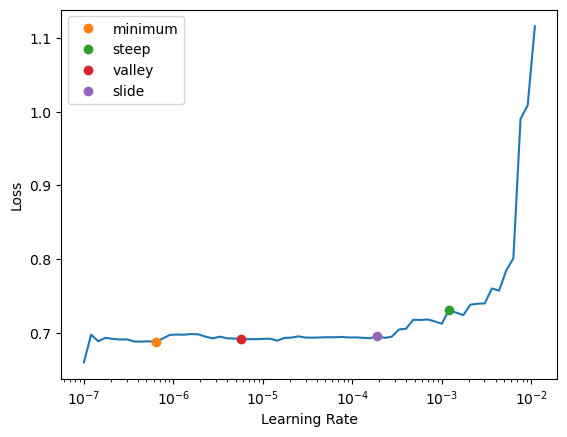

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.14847154915332794
valid_loss 0.15739987790584564
accuracy 0.9399999976158142


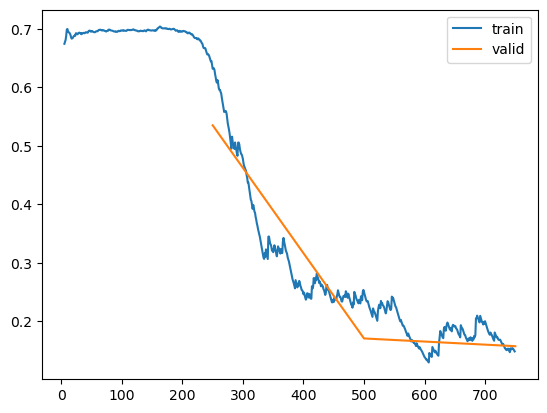

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Dataset`s (PyTorch)

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ["I wouldn't be surprised if LW had been broken up with and chose to omit that from the letter.", "Remember the huge used car lot at Kapiolani and Kalakaua?  The proposed Hawaii Convention Center was doubtless to be a success.  Hawaii was the world's most desired destination.  Tourists galore.  Business conventions galore..ect. etc. etc.  Construction became a foregone conclusion from disaster to just finish it already.  When the politics, budget problems, tax bailouts, and contract lawsuits over the poor business planning, foolhardy engineering costs estimates (ECA), and gov't subsidies were finally done, how did the Convention Center perform for the next decade?  A white elephant needing to look good for both developers and politicians to save face.  Our Legislature now welcomes the Mayor's Rail.  This time, it's not an Indonesian developer leading with glittering generalities rather than $detail, but instead, the Mayor!"], 'toxicity': [0

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# define our PyTorch Dataset class
class HFTextMultilabelClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, hf_tokenizer, labels):
        self.hf_dataset = hf_dataset
        self.hf_tokenizer = hf_tokenizer
        self.labels = labels

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        item["label"] = [item[lbl] for lbl in self.labels]
        return item


# build our PyTorch training and validation Datasets
pt_proc_civil_train_ds = HFTextMultilabelClassificationDataset(proc_civil_train_ds, hf_tokenizer=hf_tokenizer, labels=civil_label_names)
pt_proc_civil_valid_ds = HFTextMultilabelClassificationDataset(proc_civil_valid_ds, hf_tokenizer=hf_tokenizer, labels=civil_label_names)

##### Step 3: `DataLoader`s (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(pt_proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(pt_proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.00020892962347716094, steep=0.04786301031708717, valley=4.365158383734524e-05, slide=0.0006918309954926372)

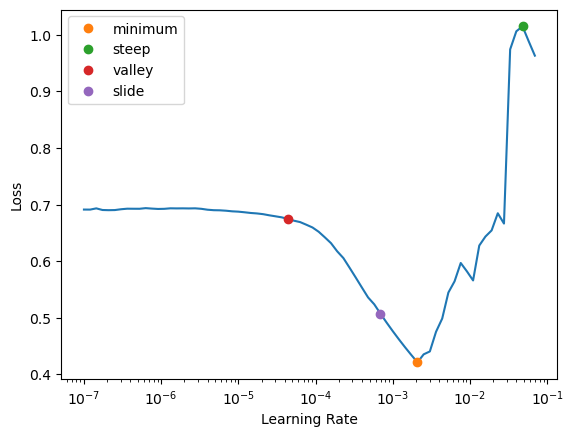

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.05448848754167557
valid_loss 0.08653034269809723
accuracy_multi 0.9785714149475098


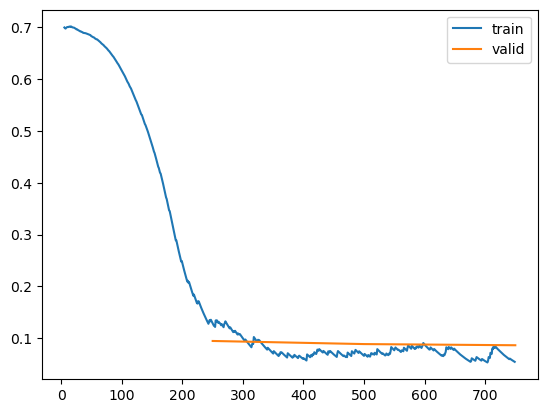

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Hugging Face

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets` (huggingface)

In [ ]:
print("Train|Validation examples: ", len(train_ds), len(valid_ds))

print(train_ds[:2])
print("")
print(train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ["Love Trap is not a short, it's quite obviously a full length feature film with a running time of 105 minutes.<br /><br />While I'm writing this, I might as well talk a bit more about Love Trap. I'm frequently asked what makes Love Trap different... this is how I respond to that question: 1) It introduces characters - one in particular - that have never been seen before in film, period.<br /><br />2) It reveals more truth about love, and delves more deeply into the very concept of love, than any other U.S. film ever made, in my humble opinion.<br /><br />3) Structurally, as in the way the story is told, it is unlike any love story you've ever seen.<br /><br />4) It offers extremely timely insights on various cultural issues, both within and outside the Black community.<br /><br />Over time, people will come to see Love Trap as about as wholly an original work as possible in this era, delightfully refreshing, authentic and honest. It is a r

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_train_ds = train_ds.map(tokenize_func, batched=True)
proc_train_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

proc_valid_ds = valid_ds.map(tokenize_func, batched=True)
proc_valid_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

print(proc_train_ds)
print(proc_valid_ds)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-38f1bc447137a0d5.arrow


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})


##### Step 3: `DataLoader`s (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=6.309573450380412e-08, steep=0.00363078061491251, valley=3.0199516913853586e-05, slide=0.0002290867705596611)

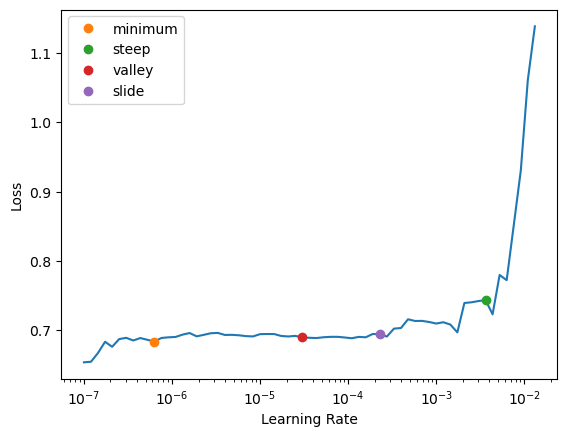

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.15749560296535492
valid_loss 0.15313708782196045
accuracy 0.9350000023841858


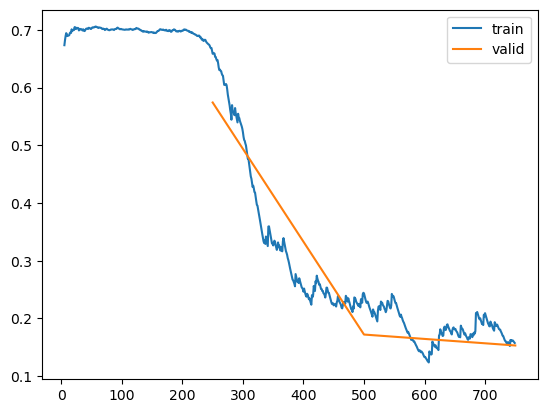

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


##### Step 2: `Datasets` (huggingface)

In [ ]:
print("Train|Validation examples: ", len(civil_train_ds), len(civil_valid_ds))

print(civil_train_ds[:2])
print("")
print(civil_train_ds["text"][:2])

Train|Validation examples:  1000 200
{'text': ["I wouldn't be surprised if LW had been broken up with and chose to omit that from the letter.", "Remember the huge used car lot at Kapiolani and Kalakaua?  The proposed Hawaii Convention Center was doubtless to be a success.  Hawaii was the world's most desired destination.  Tourists galore.  Business conventions galore..ect. etc. etc.  Construction became a foregone conclusion from disaster to just finish it already.  When the politics, budget problems, tax bailouts, and contract lawsuits over the poor business planning, foolhardy engineering costs estimates (ECA), and gov't subsidies were finally done, how did the Convention Center perform for the next decade?  A white elephant needing to look good for both developers and politicians to save face.  Our Legislature now welcomes the Mayor's Rail.  This time, it's not an Indonesian developer leading with glittering generalities rather than $detail, but instead, the Mayor!"], 'toxicity': [0

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_label_names], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_train_ds = civil_train_ds.map(tokenize_func, batched=True)
proc_civil_valid_ds = civil_valid_ds.map(tokenize_func, batched=True, batch_size=4)

print(proc_civil_train_ds)
print(proc_civil_valid_ds)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit', 'is_valid', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 200
})


##### Step 3: `DataLoader`s (PyTorch)

In [ ]:
# build your fastai `DataLoaders` from Pytorch `DataLoader` objects
batch_size = 4
data_collator = TextCollatorWithPadding(hf_tokenizer)
train_dl = torch.utils.data.DataLoader(proc_civil_train_ds, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
valid_dl = torch.utils.data.DataLoader(proc_civil_valid_ds, batch_size=batch_size * 2, shuffle=False, collate_fn=data_collator)

dls = DataLoaders(train_dl, valid_dl)

##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'show_batch'
# learn.dls.valid.show_batch()

In [ ]:
# NOPE: Won't work with PyTorch DataLoaders
# AttributeError: 'DataLoader' object has no attribute 'one_batch'
# learn.summary()

##### Step 5: Train

SuggestedLRs(minimum=0.00020892962347716094, steep=0.033113110810518265, valley=4.365158383734524e-05, slide=0.00013182566908653826)

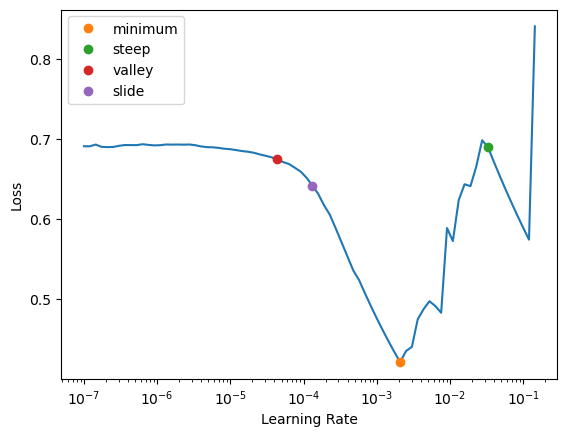

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.05448729917407036
valid_loss 0.08653184771537781
accuracy_multi 0.9785714149475098


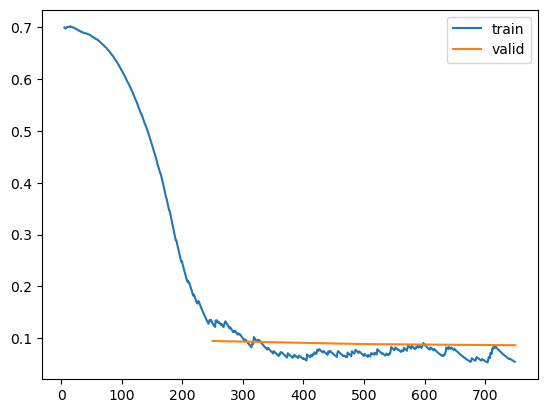

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.show_results(learner=learn, max_n=2, trunc_at=500)

In [ ]:
# NOPE: Won't work with PyTorch DataLoader
# AttributeError: 'DataLoader' object has no attribute 'new'
# learn.export("../models/test_topic_segmentation.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Low-Level API

In this section, we include a custom `show_results()` method that will work with fast.ai's low-level and mid-level (think `DataBlock`) APIs.

### `show_results` -

In [ ]:
# |export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `TextInput` typed inputs
    x: TextInput,
    # Your targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs,
):
    # grab our tokenizer
    tfm = first_blurr_tfm(learner.dls)
    hf_tokenizer = tfm.hf_tokenizer

    # if we've included our labels list, we'll use it to look up the value of our target(s)
    trg_label_names = tfm.kwargs["label_names"] if ("label_names" in tfm.kwargs) else None
    if trg_label_names is None and learner.dls.vocab is not None:
        trg_label_names = learner.dls.vocab

    res = L()
    n_inp = learner.dls.n_inp

    n_samples = min(max_n, learner.dls.bs)
    for idx in range(n_samples):
        pred = outs[idx]

        # add in the input text
        input_ids = x[idx]
        rets = [hf_tokenizer.decode(input_ids, skip_special_tokens=True)[:trunc_at]]

        # add in the targets
        sample = samples[idx] if samples is not None else None
        for item_idx, item in enumerate(sample[n_inp:]):
            label = y[item_idx] if y is not None else item

            if torch.is_tensor(label):
                label = list(label.numpy()) if len(label.size()) > 0 else label.item()

            if is_listy(label):
                trg = [trg_label_names[int(idx)] for idx, val in enumerate(label) if (val == 1)] if trg_label_names else label
            else:
                trg = trg_label_names[int(item)] if trg_label_names else item

            rets.append(trg)

        # add in the predictions
        for item in pred:
            if torch.is_tensor(item):
                item = list(item.numpy()) if len(item.size()) > 0 else item.item()

            if is_listy(item):
                p = [trg_label_names[int(idx)] for idx, val in enumerate(item) if (val == 1)] if trg_label_names else item
            else:
                p = trg_label_names[int(item)] if trg_label_names else item

            rets.append(p)

        res.append(tuplify(rets))

    cols = ["text"] + ["target" if (i == 0) else f"target_{i}" for i in range(len(res[0]) - n_inp * 2)]
    cols += ["prediction" if (i == 0) else f"prediction_{i}" for i in range(len(res[0]) - n_inp * 2)]
    display_df(pd.DataFrame(res, columns=cols)[:max_n])
    return ctxs

## Low-Level API: Examples

### Multiclass

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Datasets` (fastai)

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)
proc_imdb_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_imdb_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(imdb_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): 0


#### Step 3: `DataLoaders` (fastai)

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)
batch_decode_tfm = BatchDecodeTransform(hf_tokenizer, hf_arch, hf_config, hf_model, label_names=label_names)

dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    after_batch=batch_decode_tfm,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=8)

#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 1546)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1546 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1546 x 3072     
Linear                        

#### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=0.00019054606673307717, valley=6.30957365501672e-05, slide=0.0006918309954926372)

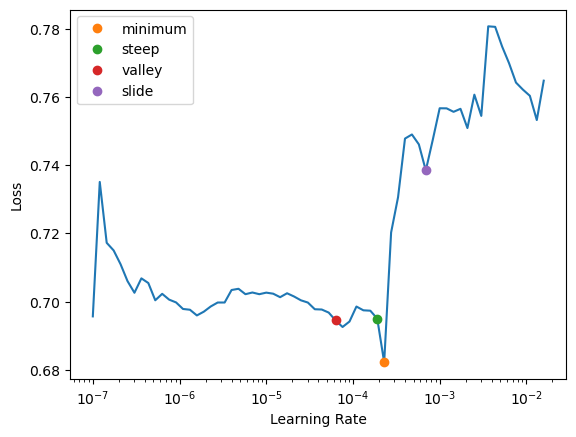

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.19418330490589142
valid_loss 0.16107948124408722
accuracy 0.9399999976158142


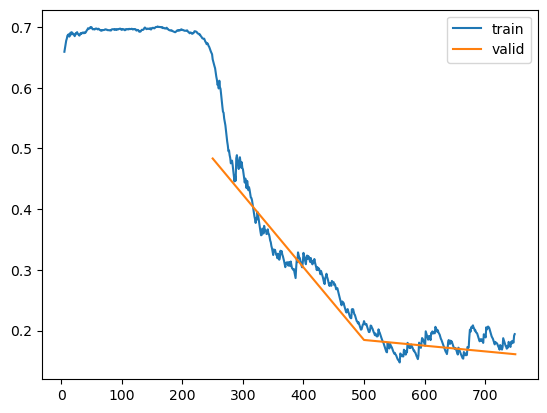

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Ah, here it is! A movie, which is said by people to remind me of the epic ""Trainspotting"". OUCH, was I a fool to believe that, and OUCH, how my buttocks hurt after having forced myself to watch this c**p from beginning to end. After the first 10-15 minutes I just wanted it all to end, or at least they could've put some nudity or action or cool acid house music into it to make it worth the time... But no, when I was through with it, i put it into my CD shelf and I hope I will never have to pick i",neg,neg
1,"LACKAWANNA BLUES is an entertaining, engrossing, emotionally-charged HBO-TV movie based on the childhood memories of actor Ruben Santiago-Hudson (who also appears in a small role). This joyous motion picture experience is centered around Santiago-Hudson's childhood guardian, Rachel ""Nanny"" Crosby, a strong, big-hearted black woman who ran a boarding house in upstate New York during the 1950's. Nanny was a one-woman social service organization whose boarding house was filled with drunks, derelict",pos,pos


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Multilabel

#### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#### Step 2: `Datasets` (fastai)

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_label_names], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)
proc_civil_ds.set_format("torch", columns=hf_tokenizer.model_input_names + ["label"])

# turn Arrow into DataFrame (`ColSplitter` only works with `DataFrame`s)
train_df = pd.DataFrame(proc_civil_ds)
train_df.head()

# define dataset splitter
splitter = ColSplitter("is_valid")
splits = splitter(civil_df)


# define how we want to build our inputs and targets
def _build_inputs(example):
    return {fwd_arg_name: example[fwd_arg_name] for fwd_arg_name in hf_tokenizer.model_input_names if fwd_arg_name in list(example.keys())}


def _build_targets(example):
    return example["label"]


# create our fastai `Datasets` object
dsets = Datasets(items=train_df, splits=splits, tfms=[[_build_inputs], _build_targets], n_inp=1)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

In [ ]:
print("Items in train|validation datasets: ", len(dsets.train), len(dsets.valid))

example = dsets.valid[0]
# example

print(f"Items in each example: {len(example)}")
print(f"Example inputs: {list(example[0].keys())}")
print(f"Example target(s): {example[1]}")

Items in train|validation datasets:  1000 200
Items in each example: 2
Example inputs: ['input_ids', 'token_type_ids', 'attention_mask']
Example target(s): tensor([0, 0, 0, 0, 0, 0, 0])


#### Step 3: `DataLoaders` (fastai)

In [ ]:
data_collator = TextCollatorWithPadding(hf_tokenizer)
sort_func = partial(sorted_dl_func, hf_tokenizer=hf_tokenizer)
batch_decode_tfm = BatchDecodeTransform(hf_tokenizer, hf_arch, hf_config, hf_model, label_names=civil_label_names)

dls = dsets.dataloaders(
    batch_size=4,
    create_batch=data_collator,
    after_batch=batch_decode_tfm,
    dl_type=partial(SortedDL, sort_func=sort_func),
)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=8)

,text,target
0,"your either an islamist or a far left(marxist) who hates Jesus Christ... there are no homicide baptists running around, genius!! ------------------------------------- THIS is hate; all from the Qur’an.” The eternal, unchanging words of Allah: Q 2:193 “And kill them [unbelievers] wherever you find them.” Q 2:216 “Fighting is prescribed for you.” Q 8:12 “I will strike terror into the hearts of those who disbelieve. Therefore strike off their heads and strike off every fingertip of them.” Q 9:5 “Slay the idolaters wherever you find them, and take them captive and besiege them and lie in wait for them in every ambush.” Q 9:123 “O you who believe! Fight those of the unbelievers who are near to you and let them find in you hardness.” Q 4:73 “So, when you meet those who disbelieve smite at their necks till when you have killed them and wounded many of them.” Q 5:14 : “We [Muslims] estranged them [Christians] with enmity and HATRED between one and the other, TO THE DAY OF JUDGMENT.”","[toxicity, identity_attack]"
1,"This article is surprising coming from 2 seemingly reasonable bush reps. But I smell a rat, or two. ""No magic bullet?"" Read, & do not fail to understand Dr.Robin Brena's clear analysis of how SB21 crippled & continues to bleed all Alaskans of their Clear & Equitable Share of oil profits. Merely restructuring the oil/gas credits is a first step, but not even close to enough. ""we lost 1,500 private sector & 1,700 public sector jobs"", our bloated gubmut got trimmed, but not nearly enough. No tears for that, Why do Seaton & Foster not address the Tyranosaurus Rex in the mix - the (what should be criminal) SB21 & its larcenous take of Alaska's profits, set up & now condoned by our own Legislators & carefully not mentioned in this transparent plea for individual Alaskan's to sacrifice their own finances to pad the profits of BigOil? Seaton & Foster lost a lot of their credibility with their authorship of this Opinion. Why are they afraid of BigOil? We should have an income & sales tax, too","[toxicity, identity_attack]"
2,"I hate riding a bike on the sidewalks. You have to go up & down & around twist & turn when crossing a street at a light. Many times I have to try not to hit a pole & if it's a skinny one & I'm watching for some breaks in the sidewalk then I might run into the pole. The other day a girl was hit at the crosswalk of Peck and Muldoon. I think the driver of the car came up to the crosswalk too quickly & was on the crosswalk at the same time a girl was crossing the street. That's what I think happened, but if not, it easily could. Drivers r supposed to stop before the crosswalk & then pull up slowly so they can c to continue, but many times they don't. Also, I think some bikers think they have the right of way & ride across a street without knowing if the car driver even sees them. Bike riders or walkers dont automatically have right of way crossing a street that doesn't have a designation light 4 right of way. I want to ride on the street.","[toxicity, identity_attack]"
3,"Thank you for responding, Zuri. I am a former Mililani resident, but my folks still live there, and I visit them almost every week. I grew up there - my family moved there in 1970. The first time Ron Menor ran for political office (his House seat), our family waved signs and canvassed the neighborhood for him. I care about the place, so when I read accusations that you weren't fulfilling your duties at the Academy, it naturally caused concern. And your comment ""If a rule has been broken"" is cause for more concern. Rules have been broken, there is no ""if"". Perhaps not by you, but by close family members that you worked alongside for years. Theft from the government is a serious breach of public trust. I realize that it's your mother, but I hope you feel some sense of sadness/anger/disappointment over what she did, otherwise it may be difficult for voters to trust your judgement. I personally wish you no ill. My concern is f

#### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# YES: Since we're using fastai `DataLoaders`, we get `one_batch()` back
learn.summary()

BaseModelWrapper (Input shape: 4 x 282)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 282 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 282 x 3072      
Linear                         

#### Step 5: Train

SuggestedLRs(minimum=0.00043651582673192023, steep=0.009120108559727669, valley=7.585775892948732e-05, slide=0.0006918309954926372)

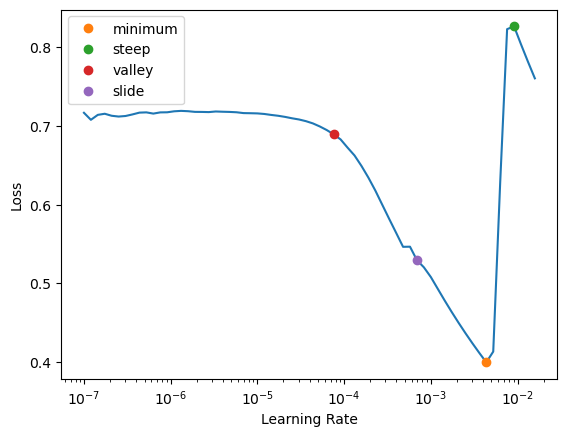

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.06750576943159103
valid_loss 0.08802632242441177
accuracy_multi 0.9785712957382202


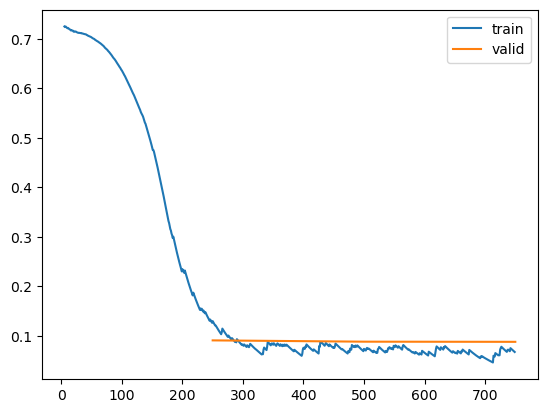

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# YES: Since we're using fastai `TfmDL` and including a transform that knows how to show our inputs,
# we get `show_results()` back
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"90% of portfolio in munis. Likely in Florida. Close to Bahamas. Guessing. 3.5% tax free. Exactly what a pal of mine does. If you have 50-100 Million, it's smooth sailing.",[],[]
1,"Great idea, draining the swamp of the good ole millionaires and putting the billionaires in for a change. Man that is originsl. 1984 anyone? Fourth Reich? New World Order? New Imperial Roman Empire? All connected to our self created and self sustaining war on terrrorism, on behalf of all of the above leeches and parasites who need America to invade other countries so the neocons can go in for free and profit off stolen resources and lands",[],[]


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`
# AttributeError: 'DataLoader' object has no attribute 'new'
learn.export("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Mid-Level API

Everything required to train transformers using the mid-level API is already there, so lets move straight to the examples

## Mid-Level API: Examples

### Pretokenized

#### Multiclass

##### Step 1: HF objects

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)


# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
txt_block = TextBlock(
    hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model, batch_decode_kwargs={"label_names": label_names}
)

blocks = (txt_block, CategoryBlock)
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

##### Step 3: `DataLoaders`

In [ ]:
# tokenize the HF dataset
def tokenize_func(example):
    return hf_tokenizer(example["text"], truncation=True)


proc_imdb_ds = imdb_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-06512a5d425e48e2.arrow


In [ ]:
dls = dblock.dataloaders(proc_imdb_ds, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=250)

,text,target
0,***SPOILERS*** ***SPOILERS*** Continued...<br /><br />From here on in the whole movie collapses in on itself. First we meet a rogue program with the indication we're gonna get ghosts and vampires and werewolves and the like. We get a guy with a retar,neg
1,"Waitress: Honey, here's them eggs you ordered. Honey, like bee, get it? That's called pointless foreshadowing.<br /><br />Edward Basket: Huh? (On the road) Basket: Here's your doll back, little girl. You really shouldn't be so careless with your belo",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"Ah, here it is! A movie, which is said by people to remind me of the epic ""Trainspotting"". OUCH, was I a fool to believe that, and OUCH, how my buttocks hurt after having forced myself to watch this c**p from beginning to end. After the first 10-15 m",neg
1,"SPOILERS<br /><br />*<br /><br />*<br /><br />*<br /><br />*<br /><br />This is Tenchi?<br /><br />This is not Tenchi.<br /><br />Practically everyone is written horribly out of character... When it comes to characterization, the only bright spot is",neg


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1546)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1546 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1546 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=0.00019054606673307717, valley=4.365158383734524e-05, slide=0.0002754228771664202)

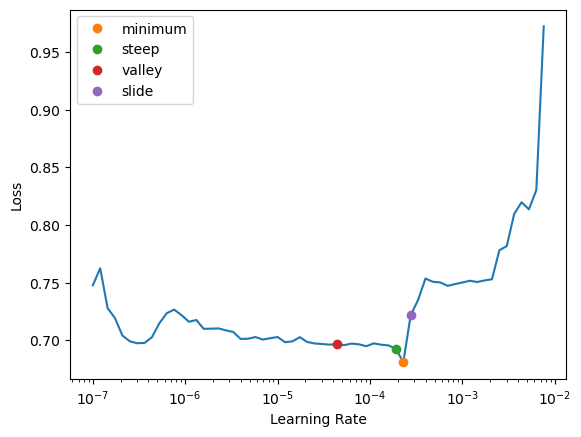

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.20377954840660095
valid_loss 0.149971142411232
accuracy 0.9350000023841858


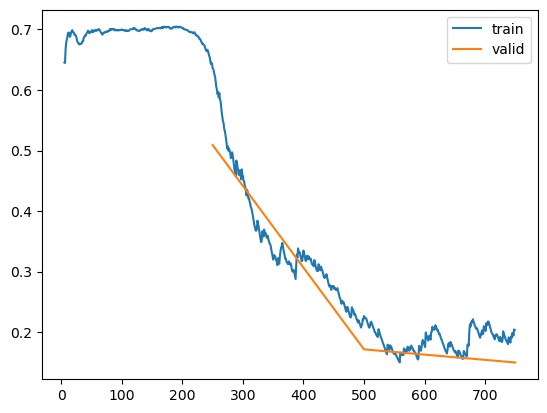

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Ah, here it is! A movie, which is said by people to remind me of the epic ""Trainspotting"". OUCH, was I a fool to believe that, and OUCH, how my buttocks hurt after having forced myself to watch this c**p from beginning to end. After the first 10-15 minutes I just wanted it all to end, or at least they could've put some nudity or action or cool acid house music into it to make it worth the time... But no, when I was through with it, i put it into my CD shelf and I hope I will never have to pick i",neg,neg
1,"LACKAWANNA BLUES is an entertaining, engrossing, emotionally-charged HBO-TV movie based on the childhood memories of actor Ruben Santiago-Hudson (who also appears in a small role). This joyous motion picture experience is centered around Santiago-Hudson's childhood guardian, Rachel ""Nanny"" Crosby, a strong, big-hearted black woman who ran a boarding house in upstate New York during the 1950's. Nanny was a one-woman social service organization whose boarding house was filled with drunks, derelict",pos,pos


In [ ]:
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
# define DataBlock splitter
def _split_func(example):
    return example["is_valid"] == True


splitter = FuncSplitter(_split_func)


# define how we want to build our targets
# note: we don't need to define how to build our inputs because we're using an HF `Dataset` in this example
def get_y(example):
    return example["label"]


# define the DataBlock
txt_block = TextBlock(hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model)

blocks = (txt_block, MultiCategoryBlock(encoded=True, vocab=civil_label_names))
dblock = DataBlock(blocks=blocks, get_y=get_y, splitter=splitter)

##### Step 3: `DataLoaders`

In [ ]:
# tokenize the dataset
def tokenize_func(example):
    updated_example = dict(hf_tokenizer(example["text"], truncation=True))
    labels = torch.stack([tensor(example[lbl]) for lbl in civil_label_names], dim=-1)
    updated_example["label"] = labels

    return updated_example


proc_civil_ds = civil_ds.map(tokenize_func, batched=True)

Loading cached processed dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-92af748e69d0b799.arrow


In [ ]:
dls = dblock.dataloaders(proc_civil_ds, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"your either an islamist or a far left(marxist) who hates Jesus Christ... there are no homicide baptists running around, genius!! ------------------------------------- THIS is hate; all from the Qur’an.” The eternal, unchanging words of Allah: Q 2:193 “And kill them [unbelievers] wherever you find them.” Q 2:216 “Fighting is prescribed for you.” Q 8:12 “I will strike terror into the hearts of those who disbelieve. Therefore strike off their heads and strike off every fingertip of them.” Q 9:5 “Sl","[toxicity, identity_attack]"
1,"This article is surprising coming from 2 seemingly reasonable bush reps. But I smell a rat, or two. ""No magic bullet?"" Read, & do not fail to understand Dr.Robin Brena's clear analysis of how SB21 crippled & continues to bleed all Alaskans of their Clear & Equitable Share of oil profits. Merely restructuring the oil/gas credits is a first step, but not even close to enough. ""we lost 1,500 private sector & 1,700 public sector jobs"", our bloated gubmut got trimmed, but not nearly enough. No tears","[toxicity, identity_attack]"


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"90% of portfolio in munis. Likely in Florida. Close to Bahamas. Guessing. 3.5% tax free. Exactly what a pal of mine does. If you have 50-100 Million, it's smooth sailing.",[]
1,This is an interesting discussion. Many Canadians do want to own a single family fully detached home with a yard. But why. Perhaps this is in part because of a desire for a place of both privacy and greenery in our lives. But perhaps it is also becau,[]


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 282)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 282 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 282 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.00043651582673192023, steep=0.0003311311302240938, valley=7.585775892948732e-05, slide=0.0010000000474974513)

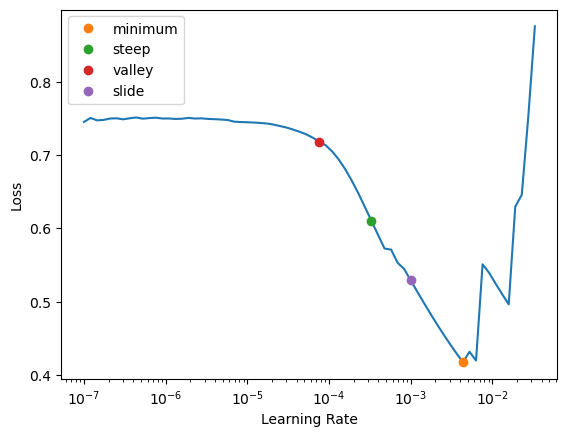

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07056152820587158
valid_loss 0.08710870891809464
accuracy_multi 0.9785712957382202


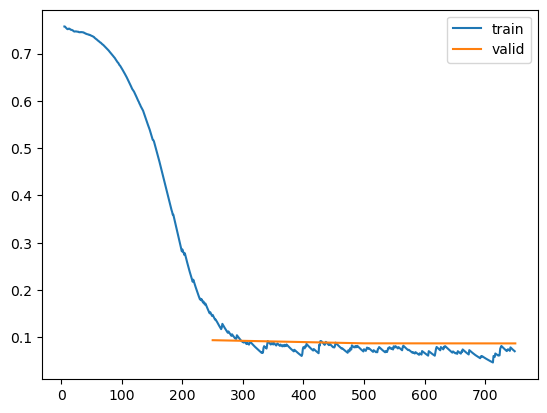

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"90% of portfolio in munis. Likely in Florida. Close to Bahamas. Guessing. 3.5% tax free. Exactly what a pal of mine does. If you have 50-100 Million, it's smooth sailing.",[],[]
1,"Great idea, draining the swamp of the good ole millionaires and putting the billionaires in for a change. Man that is originsl. 1984 anyone? Fourth Reich? New World Order? New Imperial Roman Empire? All connected to our self created and self sustaining war on terrrorism, on behalf of all of the above leeches and parasites who need America to invade other countries so the neocons can go in for free and profit off stolen resources and lands",[],[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Batch-Time Tokenization

#### Multiclass

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = BatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

blocks = (
    TextBlock(tokenize_tfm=tokenize_tfm, batch_decode_kwargs={"label_names": label_names}),
    CategoryBlock,
)
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label"),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"***SPOILERS*** ***SPOILERS*** Continued...<br /><br />From here on in the whole movie collapses in on itself. First we meet a rogue program with the indication we're gonna get ghosts and vampires and werewolves and the like. We get a guy with a retarded accent talking endless garbage, two 'ghosts' that serve no real purpose and have no character what-so-ever and a bunch of henchmen. Someone's told me they're vampires (straight out of Blade 2), but they're so undefined I didn't realise.<br /><br",neg
1,"Waitress: Honey, here's them eggs you ordered. Honey, like bee, get it? That's called pointless foreshadowing.<br /><br />Edward Basket: Huh? (On the road) Basket: Here's your doll back, little girl. You really shouldn't be so careless with your belongings.<br /><br />Little girl: Yeah, whatever.<br /><br />Crash! Boom! Whoosh! Crackle Basket: I think that something bad is about to happen.<br /><br />(Later) Basket: Mmmm. Vicodin! What the? (Tears open letter.) Wow! My ex-girl's handwriting has",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"If anyone ever assembles a compendium on modern American horror that is truly worth it's salt, there will *have* to be an entry for SF Brownrigg's ubiquetous exercize in Asylum Horror. Every time I watch this movie I am impressed by the complete econ",pos
1,"""San Francisco, Oh you marvelously desolated town, Thank You, God, for destroying it, and making bricks fall on our collective heads, and for pummeling into oblivion tens of thousands of Your innocent, obedient sheep, oh Lord, who art so merciful in",neg


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1546)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1546 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1546 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=0.00019054606673307717, valley=6.30957365501672e-05, slide=0.0002754228771664202)

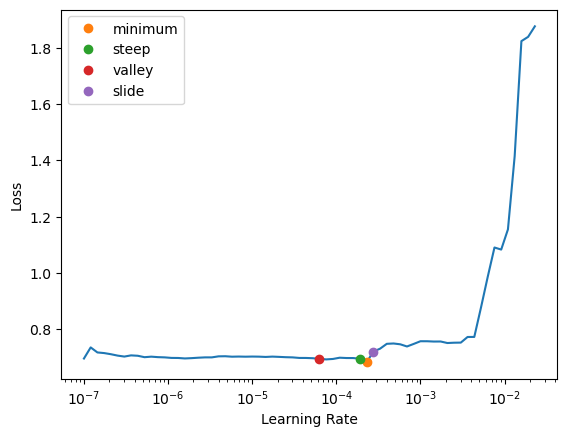

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.20711669325828552
valid_loss 0.17437581717967987
accuracy 0.9300000071525574


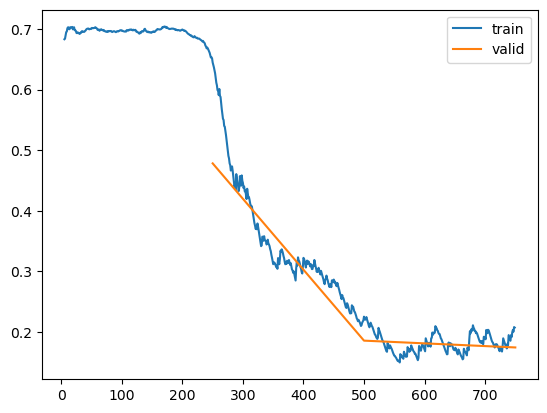

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"If anyone ever assembles a compendium on modern American horror that is truly worth it's salt, there will *have* to be an entry for SF Brownrigg's ubiquetous exercize in Asylum Horror. Every time I watch this movie I am impressed by the complete economy of the film, from the compact, totally self-contained plot with a puzzling beginning and an all too horrible ending, the engaging performances by what was essentially a group of non-professional actors, and a prevading sense of dread and claustro",pos,pos
1,"""San Francisco, Oh you marvelously desolated town, Thank You, God, for destroying it, and making bricks fall on our collective heads, and for pummeling into oblivion tens of thousands of Your innocent, obedient sheep, oh Lord, who art so merciful in thy Heavenly ways..."" These should have been the lyrics to the title song of this oh-so inspiring and utterly mindless film.<br /><br />The movie starts well enough, with Gable discovering a Cinderella with a highly annoying but much-appreciated oper",neg,neg


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tokenize_tfm = BatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model)

blocks = (TextBlock(tokenize_tfm=tokenize_tfm), MultiCategoryBlock(encoded=True, vocab=civil_label_names))
dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader(civil_label_names), splitter=ColSplitter())

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(civil_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"your either an islamist or a far left(marxist) who hates Jesus Christ... there are no homicide baptists running around, genius!! ------------------------------------- THIS is hate; all from the Qur’an.” The eternal, unchanging words of Allah: Q 2:193 “And kill them [unbelievers] wherever you find them.” Q 2:216 “Fighting is prescribed for you.” Q 8:12 “I will strike terror into the hearts of those who disbelieve. Therefore strike off their heads and strike off every fingertip of them.” Q 9:5 “Sl","[toxicity, identity_attack]"
1,"This article is surprising coming from 2 seemingly reasonable bush reps. But I smell a rat, or two. ""No magic bullet?"" Read, & do not fail to understand Dr.Robin Brena's clear analysis of how SB21 crippled & continues to bleed all Alaskans of their Clear & Equitable Share of oil profits. Merely restructuring the oil/gas credits is a first step, but not even close to enough. ""we lost 1,500 private sector & 1,700 public sector jobs"", our bloated gubmut got trimmed, but not nearly enough. No tears","[toxicity, identity_attack]"


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"@ThinkRightGM: Maybe semantics, but I prefer to focus on TYPE of demand instead of supply. Is it demand for SHELTER or is it demand for speculative investment/a toehold in a hedge city? If you compare housing completion data to pop. growth in the reg",[]
1,"Hard to predict the future and wish we could soften opinions to wait and see. Opinion is just that, an opinion. I am trying a wait and see approach. Take Education for example. US education has fallen drastically over the years...i.e., silly things t",[]


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 282)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 282 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 282 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.00043651582673192023, steep=0.0003311311302240938, valley=7.585775892948732e-05, slide=0.0006918309954926372)

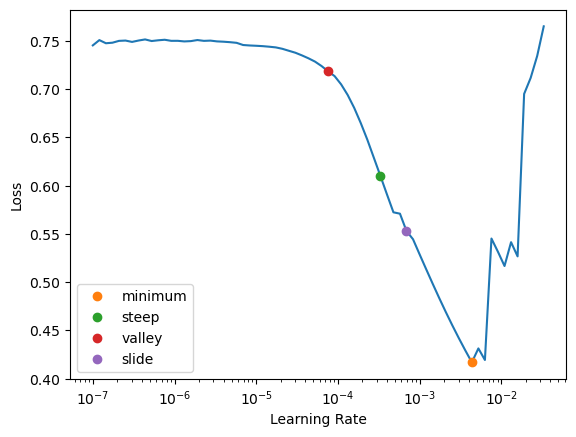

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07056257128715515
valid_loss 0.0871070846915245
accuracy_multi 0.9785712957382202


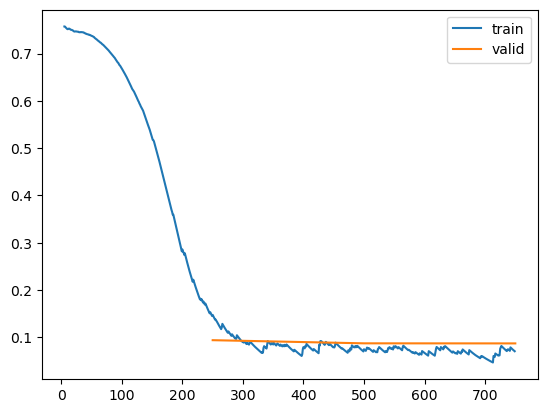

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"@ThinkRightGM: Maybe semantics, but I prefer to focus on TYPE of demand instead of supply. Is it demand for SHELTER or is it demand for speculative investment/a toehold in a hedge city? If you compare housing completion data to pop. growth in the region for recent years, it seems we are building enough shelter (those numbers divided into each other yield a number a good deal smaller than the avg. household size). So what sort of demand causes the meteoric rise in prices? It might be partly a she",[],[]
1,"Hard to predict the future and wish we could soften opinions to wait and see. Opinion is just that, an opinion. I am trying a wait and see approach. Take Education for example. US education has fallen drastically over the years...i.e., silly things that make you laugh but are not funny..65% of incoming Freshmen at U. Of Miami in Florida, could not find Florida on the map. We have known serious changes in Education are needed and yet the very same players want to continue to remain in charge. I d",[],[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

### Item-Time Tokenization

#### Multiclass

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", label_names, verbose=True)

=== config ===
# of labels:	2

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tfm = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm.split_idx = 0

tfm2 = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm2.split_idx = 1

blocks = (
    TextBlock(
        hf_arch=hf_arch,
        hf_config=hf_config,
        hf_tokenizer=hf_tokenizer,
        hf_model=hf_model,
        type_tfms=[tfm, tfm2],
        batch_decode_kwargs={"label_names": label_names},
    ),
    CategoryBlock,
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader("label"),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"***SPOILERS*** ***SPOILERS*** Continued...<br /><br />From here on in the whole movie collapses in on itself. First we meet a rogue program with the indication we're gonna get ghosts and vampires and werewolves and the like. We get a guy with a retarded accent talking endless garbage, two 'ghosts' that serve no real purpose and have no character what-so-ever and a bunch of henchmen. Someone's told me they're vampires (straight out of Blade 2), but they're so undefined I didn't realise.<br /><br",neg
1,"Waitress: Honey, here's them eggs you ordered. Honey, like bee, get it? That's called pointless foreshadowing.<br /><br />Edward Basket: Huh? (On the road) Basket: Here's your doll back, little girl. You really shouldn't be so careless with your belongings.<br /><br />Little girl: Yeah, whatever.<br /><br />Crash! Boom! Whoosh! Crackle Basket: I think that something bad is about to happen.<br /><br />(Later) Basket: Mmmm. Vicodin! What the? (Tears open letter.) Wow! My ex-girl's handwriting has",neg


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"Ah, here it is! A movie, which is said by people to remind me of the epic ""Trainspotting"". OUCH, was I a fool to believe that, and OUCH, how my buttocks hurt after having forced myself to watch this c**p from beginning to end. After the first 10-15 m",neg
1,"SPOILERS<br /><br />*<br /><br />*<br /><br />*<br /><br />*<br /><br />This is Tenchi?<br /><br />This is not Tenchi.<br /><br />Practically everyone is written horribly out of character... When it comes to characterization, the only bright spot is",neg


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 1546)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 1546 x 768      
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 1546 x 3072     
Linear                        

##### Step 5: Train

SuggestedLRs(minimum=2.290867705596611e-05, steep=0.02290867641568184, valley=6.30957365501672e-05, slide=0.00015848931798245758)

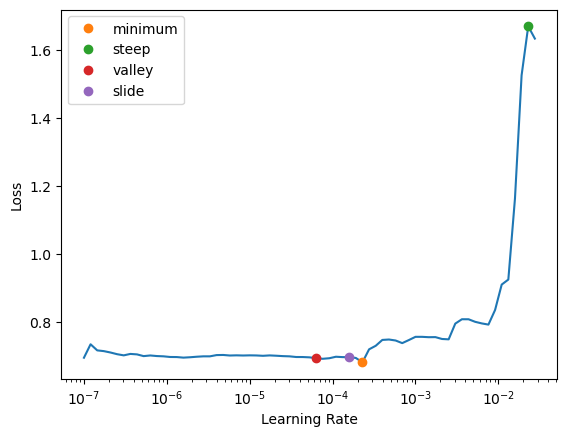

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.19911712408065796
valid_loss 0.15775194764137268
accuracy 0.9399999976158142


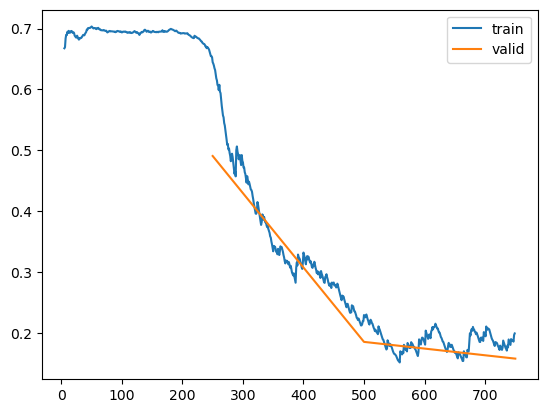

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"Ah, here it is! A movie, which is said by people to remind me of the epic ""Trainspotting"". OUCH, was I a fool to believe that, and OUCH, how my buttocks hurt after having forced myself to watch this c**p from beginning to end. After the first 10-15 minutes I just wanted it all to end, or at least they could've put some nudity or action or cool acid house music into it to make it worth the time... But no, when I was through with it, i put it into my CD shelf and I hope I will never have to pick i",neg,neg
1,"LACKAWANNA BLUES is an entertaining, engrossing, emotionally-charged HBO-TV movie based on the childhood memories of actor Ruben Santiago-Hudson (who also appears in a small role). This joyous motion picture experience is centered around Santiago-Hudson's childhood guardian, Rachel ""Nanny"" Crosby, a strong, big-hearted black woman who ran a boarding house in upstate New York during the 1950's. Nanny was a one-woman social service organization whose boarding house was filled with drunks, derelict",pos,pos


In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

#### Multilabel

##### Step 1: HF objects.

In [ ]:
# | output: false
hf_arch, hf_config, hf_tokenizer, hf_model = get_task_hf_objects("microsoft/deberta-v3-small", civil_label_names, verbose=True)

=== config ===
# of labels:	7

=== tokenizer ===
Vocab size:		128000
Max # of tokens:	1000000000000000019884624838656
Attributes expected by model in forward pass:	['input_ids', 'token_type_ids', 'attention_mask']


#####  Step 2: `DataBlock`

In [ ]:
tfm = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm.split_idx = 0

tfm2 = ItemTokenizeTransform(hf_config=hf_config, hf_tokenizer=hf_tokenizer)
tfm2.split_idx = 1

blocks = (
    TextBlock(hf_arch=hf_arch, hf_config=hf_config, hf_tokenizer=hf_tokenizer, hf_model=hf_model, type_tfms=[tfm, tfm2]),
    MultiCategoryBlock(encoded=True, vocab=civil_label_names),
)

dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("text"),
    get_y=ColReader(civil_label_names),
    splitter=ColSplitter(),
)

##### Step 3: `DataLoaders`

In [ ]:
dls = dblock.dataloaders(civil_df, bs=4)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"your either an islamist or a far left(marxist) who hates Jesus Christ... there are no homicide baptists running around, genius!! ------------------------------------- THIS is hate; all from the Qur’an.” The eternal, unchanging words of Allah: Q 2:193 “And kill them [unbelievers] wherever you find them.” Q 2:216 “Fighting is prescribed for you.” Q 8:12 “I will strike terror into the hearts of those who disbelieve. Therefore strike off their heads and strike off every fingertip of them.” Q 9:5 “Sl","[toxicity, identity_attack]"
1,"This article is surprising coming from 2 seemingly reasonable bush reps. But I smell a rat, or two. ""No magic bullet?"" Read, & do not fail to understand Dr.Robin Brena's clear analysis of how SB21 crippled & continues to bleed all Alaskans of their Clear & Equitable Share of oil profits. Merely restructuring the oil/gas credits is a first step, but not even close to enough. ""we lost 1,500 private sector & 1,700 public sector jobs"", our bloated gubmut got trimmed, but not nearly enough. No tears","[toxicity, identity_attack]"


##### Step 4: Learner

In [ ]:
set_seed()

model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(OptimWrapper, opt=torch.optim.Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter_on_head,
)

learn.loss_func.thresh = 0.15
learn.create_opt()
learn.freeze()

learn = learn.to_fp16()

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
learn.dls.valid.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"90% of portfolio in munis. Likely in Florida. Close to Bahamas. Guessing. 3.5% tax free. Exactly what a pal of mine does. If you have 50-100 Million, it's smooth sailing.",[]
1,This is an interesting discussion. Many Canadians do want to own a single family fully detached home with a yard. But why. Perhaps this is in part because of a desire for a place of both privacy and greenery in our lives. But perhaps it is also becau,[]


In [ ]:
learn.summary()

BaseModelWrapper (Input shape: 4 x 282)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 282 x 768       
Embedding                                 98380800   False     
LayerNorm                                 1536       True      
StableDropout                                                  
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
StableDropout                                                  
StableDropout                                                  
Linear                                    590592     False     
LayerNorm                                 1536       True      
StableDropout                                                  
____________________________________________________________________________
                     4 x 282 x 3072      
Linear                         

##### Step 5: Train

SuggestedLRs(minimum=0.00043651582673192023, steep=0.03981071710586548, valley=7.585775892948732e-05, slide=0.0010000000474974513)

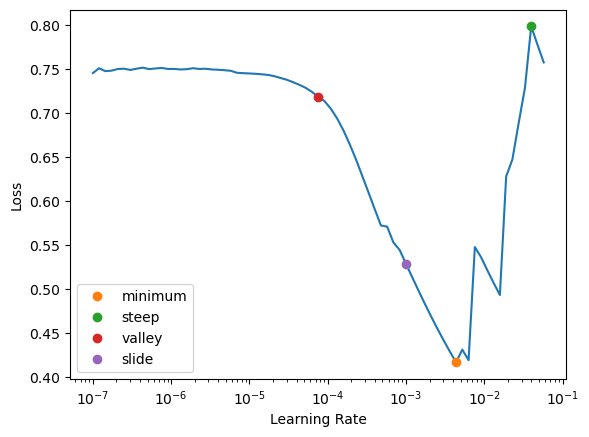

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, slice(3e-6, 3e-5))

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.07097446918487549
valid_loss 0.0876479521393776
accuracy_multi 0.9785712957382202


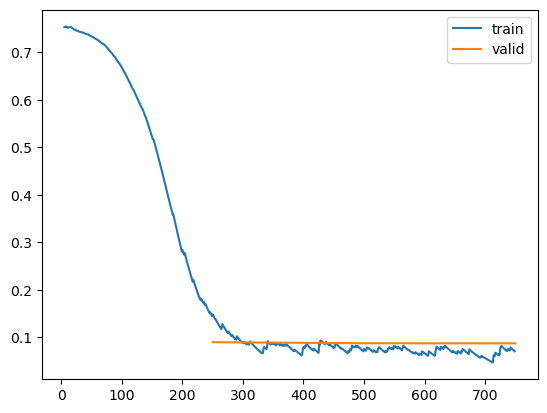

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=500)

,text,target,prediction
0,"90% of portfolio in munis. Likely in Florida. Close to Bahamas. Guessing. 3.5% tax free. Exactly what a pal of mine does. If you have 50-100 Million, it's smooth sailing.",[],[]
1,"Great idea, draining the swamp of the good ole millionaires and putting the billionaires in for a change. Man that is originsl. 1984 anyone? Fourth Reich? New World Order? New Imperial Roman Empire? All connected to our self created and self sustaining war on terrrorism, on behalf of all of the above leeches and parasites who need America to invade other countries so the neocons can go in for free and profit off stolen resources and lands",[],[]


In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape

(torch.Size([200, 7]), torch.Size([200, 7]), torch.Size([200]))

In [ ]:
# YES: Will work now that we're using fastai `Datasets`, `DataLoaders`, and transforms
learn.export("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
# |echo:false
try:
    del learn, hf_model
except:
    pass
finally:
    clean_memory()

## Inference

We need to replace fastai's `Learner.predict` method with the one above which is able to work with inputs that are represented by multiple tensors included in a dictionary.

In [ ]:
# |export
@patch
def blurr_predict(self: Learner, items, rm_type_tfms=None, tok_is_split_into_words=False):
    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)
    batch_tok_tfm = get_blurr_tfm(self.dls.before_batch, tfm_class=BatchTokenizeTransform)
    item_tok_tfm = getattr(self.dls.dataset, "item_tokenize_transform", None)

    hf_tokenizer = tfm.hf_tokenizer
    trg_labels = tfm.kwargs["label_names"] if ("label_names" in tfm.kwargs) else None

    is_split_into_words = getattr(tfm, "is_split_into_words", tok_is_split_into_words)
    is_split_str = is_split_into_words == True and isinstance(items[0], str)
    is_df = isinstance(items, pd.DataFrame)

    if not is_df and (is_split_str or not is_listy(items)):
        items = [items]

    # we need to tokenize our items *if* we are not using the mid-level API batch-time tokenization
    if batch_tok_tfm is None and item_tok_tfm is None:
        inputs_d = dict(
            hf_tokenizer(
                items, is_split_into_words=is_split_into_words, padding=True, max_length=True, truncation=True, return_tensors="pt"
            )
        )
        items = [{k: inputs_d[k][idx] for k in inputs_d.keys()} for idx in range(len(inputs_d["input_ids"]))]

    dl = self.dls.test_dl(items, rm_type_tfms=rm_type_tfms, num_workers=0)

    with self.no_bar():
        probs, _, decoded_preds = self.get_preds(dl=dl, with_input=False, with_decoded=True)

    trg_tfms = self.dls.tfms[self.dls.n_inp :]

    outs = []
    is_multilabel = isinstance(self.loss_func, BCEWithLogitsLossFlat)
    probs, decoded_preds = L(probs), L(decoded_preds)
    for i in range(len(items)):
        item_probs = probs.itemgot(i)
        item_dec_preds = decoded_preds.itemgot(i)
        item_dec_labels = tuplify([tfm.decode(item_dec_preds[tfm_idx]) for tfm_idx, tfm in enumerate(trg_tfms)])[0]

        if trg_labels:
            # handle multiclass output
            if isinstance(item_dec_labels, str) or isinstance(item_dec_labels, int):
                item_dec_labels = [trg_labels[int(item_dec_labels)]]
            elif len(item_dec_labels.size()) == 0:
                item_dec_labels = [item_dec_labels.item()]
            # handle multilabel output
            else:
                item_dec_labels = [trg_labels[lbl_idx] for lbl_idx, lbl in enumerate(item_dec_labels) if lbl == True]

        res = {}
        if is_multilabel:
            res["labels"] = list(item_dec_labels)
            msk = item_dec_preds[0]
            res["scores"] = item_probs[0][msk].tolist()
            res["class_indices"] = [int(val) for val in item_dec_preds[0]]
        else:
            res["label"] = item_dec_labels[0]
            res["score"] = item_probs[0].tolist()[item_dec_preds[0]]
            res["class_index"] = item_dec_preds[0].item()

        if trg_labels is not None or hasattr(self.dls, "vocab"):
            res["class_labels"] = trg_labels if trg_labels else self.dls.vocab
        else:
            res["class_labels"] = None

        res["probs"] = item_probs[0].tolist()

        outs.append(res)
    return outs

In [ ]:
nbdev.show_doc(Learner.blurr_predict)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/core.py#L220){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_predict

>      Learner.blurr_predict (items, rm_type_tfms=None,
>                             tok_is_split_into_words=False)

### Multiclass

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level.pkl")

In [ ]:
inf_learn.blurr_predict("This is perhaps the best movie I have ever seen!!!")

[{'label': 1,
  'score': 0.8331332802772522,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.166866734623909, 0.8331332802772522]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 1,
  'score': 0.836669385433197,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.16333059966564178, 0.836669385433197]},
 {'label': 0,
  'score': 0.5347520112991333,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.5347520112991333, 0.4652480185031891]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_mid_level.pkl")

In [ ]:
inf_learn.blurr_predict("Acting was so bad it was almost funny.")

[{'label': 'neg',
  'score': 0.7486958503723145,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.7486958503723145, 0.25130411982536316]}]

In [ ]:
inf_learn.blurr_predict(["I really liked the movie", "Worse movie I ever saw"])

[{'label': 'pos',
  'score': 0.8382017016410828,
  'class_index': 1,
  'class_labels': ['neg', 'pos'],
  'probs': [0.16179831326007843, 0.8382017016410828]},
 {'label': 'neg',
  'score': 0.5699967741966248,
  'class_index': 0,
  'class_labels': ['neg', 'pos'],
  'probs': [0.5699967741966248, 0.43000322580337524]}]

### Multilabel

In [ ]:
inf_learn = load_learner("../models/test_text_core_low_level_multilabel.pkl")

In [ ]:
inf_learn.blurr_predict("I will tell everyone what you did if you tell you jerk!")

[{'labels': [],
  'scores': [],
  'class_indices': [0, 0, 0, 0, 0, 0, 0],
  'class_labels': ['toxicity',
   'severe_toxicity',
   'obscene',
   'threat',
   'insult',
   'identity_attack',
   'sexual_explicit'],
  'probs': [0.04274217039346695,
   0.0009182040812447667,
   0.004526439588516951,
   0.001266723615117371,
   0.02985343523323536,
   0.0026660338044166565,
   0.002255573170259595]}]

In [ ]:
inf_learn = load_learner("../models/test_text_core_mid_level_multilabel.pkl")

In [ ]:
inf_learn.loss_func.thresh = 0.02


comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes.
No enchiladas for them!
"""
inf_learn.blurr_predict(comment)

[{'labels': ['toxicity', 'insult'],
  'scores': [0.04368186742067337, 0.030383974313735962],
  'class_indices': [1, 0, 0, 0, 1, 0, 0],
  'class_labels': ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
  'probs': [0.04368186742067337,
   0.0009039806318469346,
   0.00436973012983799,
   0.001199411926791072,
   0.030383974313735962,
   0.00297413463704288,
   0.0020056988578289747]}]

In [ ]:
# |echo:false
try:
    del inf_learn
except:
    pass
finally:
    clean_memory()

## Text Generation

With regards to **text generation**, though not useful in sequence classification, we will also add a `blurr_generate` method to `Learner` that uses Hugging Face's `PreTrainedModel.generate` for text generation tasks.  

For the full list of arguments you can pass in see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate). You can also check out their ["How To Generate"](https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb) notebook for more information about how it all works.

In [ ]:
# |export
@patch
def blurr_generate(self: Learner, items, key="generated_texts", **kwargs):
    """Uses the built-in `generate` method to generate the text
    (see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
    for a list of arguments you can pass in)
    """
    if not is_listy(items):
        items = [items]

    # grab our blurr tfm with the bits to properly decode/show our inputs/targets
    tfm = first_blurr_tfm(self.dls)

    # grab the Hugging Face tokenizer from the learner's dls.tfms
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs

    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    results = []
    for idx, inp in enumerate(items):
        if isinstance(inp, str):
            input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors="pt", **tok_kwargs)
        else:
            # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
            input_ids = inp.as_subclass(Tensor)

        input_ids = input_ids.to(self.model.hf_model.device)

        gen_texts = self.model.hf_model.generate(input_ids, **text_gen_kwargs)
        outputs = [hf_tokenizer.decode(txt, skip_special_tokens=True, clean_up_tokenization_spaces=False) for txt in gen_texts]

        if tfm.hf_arch == "pegasus":
            outputs = [o.replace("<n>", " ") for o in outputs]

        results.append({key: outputs[0] if len(outputs) == 1 else outputs})

    return results

In [ ]:
nbdev.show_doc(Learner.blurr_generate)

---

[source](https://github.com/ohmeow/blurr/blob/dev-3.0.0 #master/blurr/training/core.py#L293){target="_blank" style="float:right; font-size:smaller"}

### Learner.blurr_generate

>      Learner.blurr_generate (items, key='generated_texts', **kwargs)

Uses the built-in `generate` method to generate the text
(see [here](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.generate)
for a list of arguments you can pass in)

## Tests

The tests below to ensure the core DataBlock code above works for **all** pretrained sequence classification models available in Hugging Face.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained classification models you are working with ... and if any of your pretrained sequence classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

## Export -

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()